In [41]:
import igraph as ig
import geopandas as gpd
import itertools as it
import numpy as np

from eptnr.data_generation.utils.synthetic_data_generation import (
    graph_walking_edges_generation,
    set_eptnr_vertices,
    graph_edge_entry,
)
from eptnr.data_generation.utils.eptnr_vertex import EPTNRVertex
from eptnr.constants.igraph_edge_types import IGraphEdgeTypes
from eptnr.constants.igraph_vertex_types import IGraphVertexTypes
from eptnr.constants.igraph_colors import IGraphColors
from eptnr.data_generation.utils.synthetic_speeds import SyntheticTravelSpeeds

# Graph

In [42]:
g = ig.Graph(directed=True)

In [43]:
red_n_residential = 500
red_mean_walking_time_from_pt_stop = 4  # in minutes
red_std_walking_time_from_pt_stop = 1  # in minutes

purple_n_residential = 100
purple_mean_walking_time_from_pt_stop = 8  # in minutes
purple_std_walking_time_from_pt_stop = 1   # in minutes

def get_random_points_from_origin(origin: EPTNRVertex, radius_mean: float, radius_std: float, n_points: int,
                                  vertex_color: IGraphColors, vertex_type: IGraphVertexTypes):
    """ Function that returns a random point on a circle with a normal distribution on the radius """
    rs = np.random.normal(radius_mean, radius_std, n_points)
    thetas = 2 * np.pi * np.random.random(n_points)
    print(origin)
    xs = origin.x + rs * np.cos(thetas)
    ys = origin.y + rs * np.sin(thetas)

    return [EPTNRVertex(x, y, vertex_color, vertex_type) for x, y in zip(xs, ys)]

pt_vertices = [
    # Public Transport Nodes
    EPTNRVertex(5, 1, IGraphColors.BLUE, IGraphVertexTypes.PT_NODE), # RED centrum
    EPTNRVertex(4, 2, IGraphColors.BLUE, IGraphVertexTypes.PT_NODE), # POI stop
    EPTNRVertex(1, 5, IGraphColors.BLUE, IGraphVertexTypes.PT_NODE), # PURPLE centrum
]

poi_vertes = [
    # Point of Interest Nodes
    EPTNRVertex(3.9, 2.1, IGraphColors.GREEN, IGraphVertexTypes.POI_NODE),
]

residential_vertices = []

def add_distributed_neighborhoods(n_rcs: int, origin: EPTNRVertex, travel_time_mean: float, travel_time_std: float,
                                  vertex_color: IGraphColors, vertex_type: IGraphVertexTypes):
    dist_mean = (SyntheticTravelSpeeds.WALKING_SPEED.value / 60) * travel_time_mean
    dist_std = (SyntheticTravelSpeeds.WALKING_SPEED.value / 60) * travel_time_std
    residential_vertices.extend(get_random_points_from_origin(origin=origin, radius_mean=dist_mean, radius_std=dist_std,
                                                              n_points=n_rcs, vertex_color=vertex_color, vertex_type=vertex_type))

# RED Population
add_distributed_neighborhoods(n_rcs=red_n_residential, origin=pt_vertices[0], travel_time_mean=red_mean_walking_time_from_pt_stop,
                              travel_time_std=red_std_walking_time_from_pt_stop, vertex_color=IGraphColors.RED, vertex_type=IGraphVertexTypes.RC_NODE)

# PURPLE Population
add_distributed_neighborhoods(n_rcs=purple_n_residential, origin=pt_vertices[2], travel_time_mean=purple_mean_walking_time_from_pt_stop,
                              travel_time_std=purple_std_walking_time_from_pt_stop, vertex_color=IGraphColors.PURPLE, vertex_type=IGraphVertexTypes.RC_NODE)

vertices = pt_vertices + poi_vertes + residential_vertices

set_eptnr_vertices(graph=g, vertices=vertices)

EPTNRVertex(x=5, y=1, color=<IGraphColors.BLUE: 'blue'>, type=<IGraphVertexTypes.PT_NODE: 'pt_node'>)
EPTNRVertex(x=1, y=5, color=<IGraphColors.BLUE: 'blue'>, type=<IGraphVertexTypes.PT_NODE: 'pt_node'>)


## Edges
### Walking

In [44]:
graph_walking_edges_generation(graph=g, vertices=vertices)


### PT

In [45]:
E_BUS = [
    (vertices[0], vertices[1]),  # Bus_line_1 | RED to POI
    (vertices[0], vertices[1]),  # Bus_line_1 | RED to POI
    # (vertices[0], vertices[1]),  # Bus_line_2 | RED to POI
    # (vertices[0], vertices[1]),  # Bus_line_2 | RED to POI
    # (vertices[0], vertices[1]),  # Bus_line_3 | RED to POI
    # (vertices[0], vertices[1]),  # Bus_line_3 | RED to POI

    (vertices[2], vertices[1]),  # Bus_line_4 | PURPLE to POI
    (vertices[2], vertices[1]),  # Bus_line_4 | PURPLE to POI
    # (vertices[2], vertices[1]),  # Bus_line_5 | PURPLE to POI
    # (vertices[2], vertices[1]),  # Bus_line_5 | PURPLE to POI
]
names = list(it.repeat(f'Bus_line_1',2)) + list(it.repeat(f'Bus_line_2',2)) + list(it.repeat(f'Bus_line_3',2)) + list(it.repeat(f'Bus_line_4',2))

graph_edge_entry(
    graph=g,
    edges=E_BUS,
    names=names,
    speed=SyntheticTravelSpeeds.BUS_SPEED,
    edge_type=IGraphEdgeTypes.BUS,
    color=IGraphColors.PINK,
    round_to_decimals=2,
    fixed_travel_times=[
        # RED
        2, 4, #10, 10, 20, 20,
        # PURPLE
        5, 10, #20, 20
    ],
    fixed_costs=[
        # RED
        11, 11, #7, 7, 5, 5,
        # PURPLE
        11, 11, #19, 19
    ],
)

In [46]:
g.es['active'] = 1


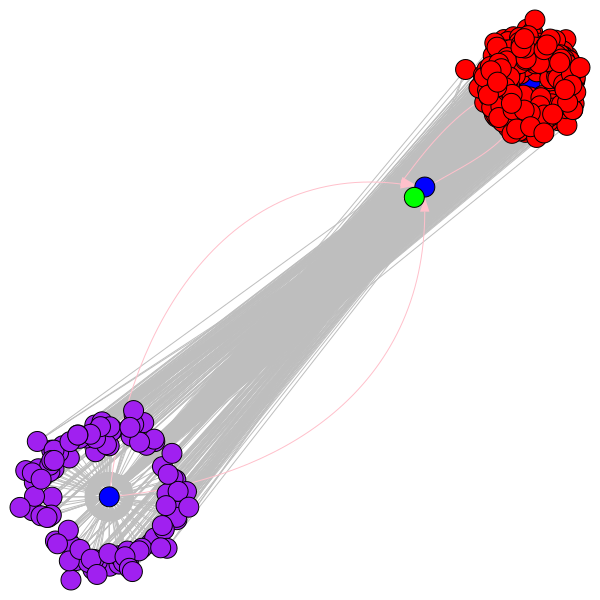

In [47]:
ig.plot(g)

## Write graph to file

In [48]:
g.write_picklez('../datasets/synthetic_6/graph.picklez')

# Census Data

In [49]:
neighborhood = [v.name for v in residential_vertices]
n_inh = [1 for _ in residential_vertices]

purple_pop_arr = np.array([True if v.color == IGraphColors.PURPLE else False for v in residential_vertices])
n_purple = purple_pop_arr.astype(int)
n_red = (~purple_pop_arr).astype(int)

p = {'x': [v.x for v in residential_vertices] , 'y': [v.y for v in residential_vertices]}
res_centroids = gpd.points_from_xy(p['x'], p['y'])

data = {
    'neighborhood': neighborhood,
    'n_inh': n_inh,
    'n_purple': n_purple,
    'n_red': n_red,
    'res_centroids': res_centroids
}

gdf = gpd.GeoDataFrame(data, geometry='res_centroids')
gdf

,neighborhood,n_inh,n_purple,n_red,res_centroids
0,RC4,1,0,1,POINT (5.18189 1.31304)
1,RC5,1,0,1,POINT (5.26940 1.12180)
2,RC6,1,0,1,POINT (5.26782 1.24550)
3,RC7,1,0,1,POINT (4.74172 0.81261)
4,RC8,1,0,1,POINT (5.24149 0.72355)
...,...,...,...,...,...
595,RC599,1,1,0,POINT (1.48905 5.49364)
596,RC600,1,1,0,POINT (1.19132 5.69164)
597,RC601,1,1,0,POINT (1.75628 5.09989)
598,RC602,1,1,0,POINT (0.47678 4.64744)


## Write graph to file

In [50]:
gdf.to_file('../datasets/synthetic_6/census_data.geojson', driver='GeoJSON')